# CMIP6 Landmask

**Following steps are included in this script:**

1. Load netCDF files
2. Create Landmask (use preprocessed data set)
3. Apply Landmask
4. Save and replace netcdf files

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
import math
from dask.diagnostics import ProgressBar
import importlib

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [2]:
def find_first_datapoint(ds_dict, variable):
    
    data = ds_dict[list(ds_dict.keys())[0]][variable]

    # Find the first time index with non-NaN values
    non_nan_time_index = data.notnull().any(dim=["lat", "lon"]).argmax().values

    # Find the first time index with non-zero values
    non_zero_time_index = (data != 0).any(dim=["lat", "lon"]).argmax().values

    # Find the maximum of both time indices to get the first time index with actual values
    first_actual_values_time_index = max(non_nan_time_index, non_zero_time_index)

    first_actual_values_time = data.time.isel(time=first_actual_values_time_index).values

    print("First time index with actual values:", first_actual_values_time_index)
    print("First time with actual values:", first_actual_values_time)

In [37]:
def apply_landmask(ds_dict):
    
    # Load landmask
    filename = 'land_sea_mask_1x1_grid.nc'
    savepath = '/work/ch0636/g300115/phd_project/common/data/external/landmask/'
    print(os.path.join(savepath, filename))
    landmask = ld.open_dataset(os.path.join(savepath, filename))
    landmask.landseamask.plot()

    # Apply landmask on data
    for i, (name, ds) in enumerate(ds_dict.items()):
        masked_ds = ds * landmask.landseamask
        print(f'Landmask applied on {name}.')
        
        masked_ds.attrs = ds.attrs
        # Add comment about changes to data 
        if 'log' in masked_ds.attrs:
            log_old = masked_ds.attrs['log']
            masked_ds.attrs['log'] = f'IMERG Land-Sea Mask NetCDF 25%-landmask applied. // {log_old}'
        else:
            masked_ds.attrs['log'] = 'IMERG Land-Sea Mask NetCDF 25%-landmask applied.'   
            
        for var in ds.variables:
            masked_ds[var].attrs = ds[var].attrs
        
        ds_dict[name] = masked_ds
    
    return ds_dict

In [3]:
def def_landmask(ds_dict):
    
    ### Time coordinates and grid must be equal###
    
    # use lai as land variable to create landmask (check before if reference dataset has values at all land points)
    landmask = (ds_dict[list(ds_dict.keys())[0]]['lai']).astype(int)
    
    # print unique values
    print(f"Unique values:", np.unique(landmask.isel(time=0).values))
    
    # set all numbers below or equal to zero to nan
    landmask = landmask.where(landmask >= 0)
    
    # set all numbers above zero to 1
    landmask = landmask.where(landmask.isnull(), 1)
    
    # save landmask
    filename = f'CMIP.{ds_dict[list(ds_dict.keys())[0]].experiment_id}.landmask_{ds_dict[list(ds_dict.keys())[0]].source_id}.nc'
    savepath = f'../../data/CMIP6/{ds_dict[list(ds_dict.keys())[0]].experiment_id}/landmask/'
    nc_out = os.path.join(savepath, filename)
    os.makedirs(savepath, exist_ok=True) 
    if os.path.exists(nc_out):
        inp = input(f"Delete old file {filename} (y/n):")
        if inp.lower() in ["y"]:
            os.remove(nc_out)
            print(f"File  with path: {nc_out} removed")
        else:
            filename = "temp_file.nc"
            nc_out = os.path.join(savepath, filename)
            print(f"Filename change to {filename}")
    # Save to netcdf file
    landmask.to_netcdf(nc_out)
    print(f"File with path: {nc_out} saved")
    
    return nc_out

### 1. Load netCDF files

In [39]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['ps', 'huss', 'evspsbl', 'tran', 'gpp', 'tas', 'pr', 'lai', 'mrso', 'mrro'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'huss' in model 'CAMS-CSM1-0'.
No file found for variable 'gpp' in model 'CAMS-CSM1-0'.
Model 'CAMS-CSM1-0' is missing variables: huss, gpp
No file found for variable 'gpp' in model 'GFDL-ESM4'.
Model 'GFDL-ESM4' is missing variables: gpp
[########################################] | 100% Completed | 68.16 s


['ssp370']


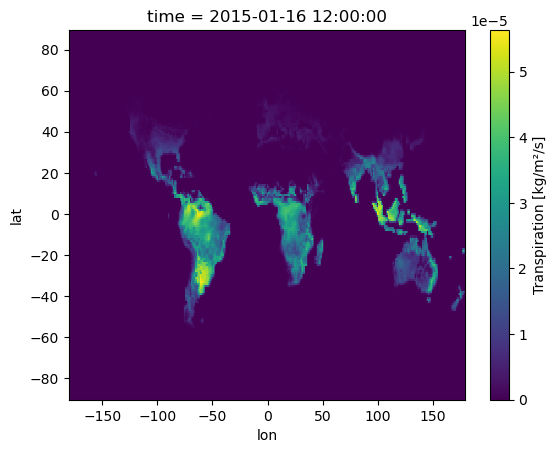

In [23]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[12]][variables[3]].isel(time=0).plot()

### 2. Apply Landmask

/work/ch0636/g300115/phd_project/common/data/external/landmask/land_sea_mask_1x1_grid.nc
Landmask applied on BCC-CSM2-MR.
Landmask applied on CAMS-CSM1-0.
Landmask applied on CESM2-WACCM.
Landmask applied on CNRM-ESM2-1.
Landmask applied on GISS-E2-1-G.
Landmask applied on MIROC-ES2L.
Landmask applied on NorESM2-MM.
Landmask applied on UKESM1-0-LL.
Landmask applied on CanESM5.
Landmask applied on CNRM-CM6-1.
Landmask applied on GFDL-ESM4.
Landmask applied on MPI-ESM1-2-LR.
Landmask applied on TaiESM1.


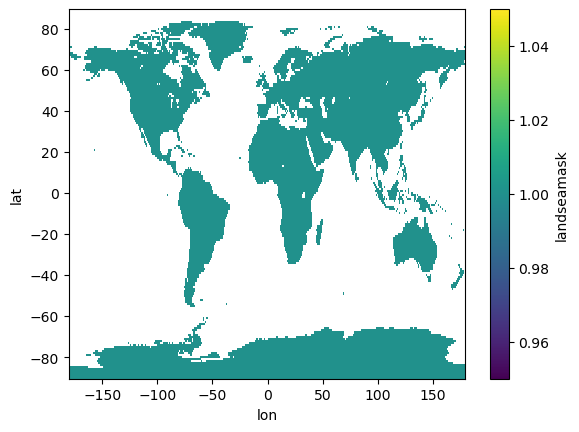

In [40]:
ds_dict = apply_landmask(ds_dict[experiments[0]])

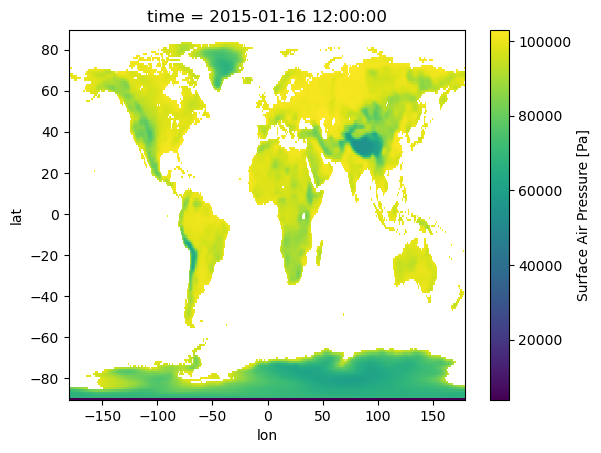

In [54]:
ds_dict[list(ds_dict.keys())[12]][variables[0]].isel(time=0).plot()

### 3. Save and replace netcdf files

In [55]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [56]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/gpp/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/